## Laufzeitanalyse Shapiq vs Shap

In [6]:
import shapiq
import shap
import sklearn
import sklearn.ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import time
import numpy as np

x_bike_sharing, y_bike_sharing = shapiq.datasets.load_bike_sharing(to_numpy=True)
x_california_housing, y_california_housing = shapiq.datasets.load_california_housing(to_numpy=True)

model_bike_sharing = sklearn.ensemble.RandomForestRegressor()
model_california_housing = sklearn.ensemble.RandomForestRegressor()

x_bike_sharing_train, x_bike_sharing_test, y_bike_sharing_train, y_bike_sharing_test = (
    train_test_split(x_bike_sharing, y_bike_sharing, train_size=0.8)
)
(
    x_california_housing_train,
    x_california_housing_test,
    y_california_housing_train,
    y_california_housing_test,
) = train_test_split(x_california_housing, y_california_housing, train_size=0.8)

model_bike_sharing.fit(x_bike_sharing_train, y_bike_sharing_train)
model_california_housing.fit(x_california_housing_train, y_california_housing_train)

RandomForestRegressor()

Training a Random Forest Regression model on both datasets.

In [7]:
imputer = ["marginal", "conditional"]

SVARM_bike_sharing = shapiq.approximator.SVARM(n=x_bike_sharing.shape[1])
PermutationSamplingSV_bike_sharing = shapiq.approximator.PermutationSamplingSV(
    n=x_bike_sharing.shape[1]
)
KernelSHAP_bike_sharing = shapiq.approximator.KernelSHAP(n=x_bike_sharing.shape[1])

SVARM_california_housing = shapiq.approximator.SVARM(n=x_california_housing.shape[1])
PermutationSamplingSV_california_housing = shapiq.approximator.PermutationSamplingSV(
    n=x_california_housing.shape[1]
)
KernelSHAP_california_housing = shapiq.approximator.KernelSHAP(n=x_california_housing.shape[1])

approximators_california_housing = (
    SVARM_california_housing,
    PermutationSamplingSV_california_housing,
    KernelSHAP_california_housing,
)
approximators_bike_sharing = (
    SVARM_bike_sharing,
    PermutationSamplingSV_bike_sharing,
    KernelSHAP_bike_sharing,
)

explainers_california_housing = []
games_california_housing = []
explainers_bike_sharing = []
games_bike_sharing = []

for imp in imputer:
    for app in approximators_bike_sharing:
        explainers_bike_sharing.append(
            shapiq.explainer.tabular.TabularExplainer(
                model=model_bike_sharing, data=x_bike_sharing_test, imputer=imp, approximator=app
            )
        )
    for app in approximators_california_housing:
        explainers_california_housing.append(
            shapiq.explainer.tabular.TabularExplainer(
                model=model_california_housing,
                data=x_california_housing_test,
                imputer=imp,
                approximator=app,
            )
        )
    for i in range(50):
        exact_computer_california_housing = shapiq.ExactComputer(
            x_california_housing.shape[1],
            game=shapiq.games.benchmark.local_xai.benchmark_tabular.CaliforniaHousing(
                x=x_california_housing_test[i], model_name="random_forest", imputer=imp
            ),
        )
        games_california_housing.append(exact_computer_california_housing(index="SV"))
        exact_computer_bike_sharing = shapiq.ExactComputer(
            x_bike_sharing.shape[1],
            game=shapiq.games.benchmark.local_xai.benchmark_tabular.BikeSharing(
                x=x_bike_sharing_test[i], model_name="random_forest", imputer=imp
            ),
        )
        games_bike_sharing.append(exact_computer_bike_sharing(index="SV"))

Creating explainer objects for all combinations of imputers and approximators given in the task.

Also computing the exact InteractionValue for the first 50 intances of the test sets. Storing the values for the marginal Imputer in the first 50 entries to the games list and the values for the conditional Imputer in the last 50.

In [9]:
def first_50_vals_california_housing(explainer):
    imp = 0
    if explainers_california_housing.index(explainer) > 2:
        imp = 50
    errors = []
    runtimes = []
    for i in range(50):
        sv_exact = games_california_housing[i + imp]
        sv_start = time.perf_counter()
        sv = explainer.explain_function(x_california_housing_test[i], budget=100)
        sv_end = time.perf_counter()
        runtimes.append(sv_end - sv_start)
        sv_exact[0] = sv[0]
        errors.append(mean_squared_error(sv.values, sv_exact.values))
    return errors, runtimes


def first_50_vals_bike_sharing(explainer):
    imp = 0
    if explainers_bike_sharing.index(explainer) > 2:
        imp = 50
    errors = []
    runtimes = []
    for i in range(50):
        sv_exact = games_bike_sharing[i + imp]
        sv_start = time.perf_counter()
        sv = explainer.explain_function(x_bike_sharing_test[i], budget=100)
        sv_end = time.perf_counter()
        runtimes.append(sv_end - sv_start)
        sv_exact[0] = sv[0]
        errors.append(mean_squared_error(sv.values, sv_exact.values))
    return errors, runtimes

In [29]:
errors_california_housing = []
runtimes_california_housing = []
errors_bike_sharing = []
runtimes_bike_sharing = []

for explainer in explainers_california_housing:
    errors, runtimes = first_50_vals_california_housing(explainer)
    errors_california_housing.append(errors)
    runtimes_california_housing.append(runtimes)

for explainer in explainers_bike_sharing:
    errors, runtimes = first_50_vals_bike_sharing(explainer)
    errors_bike_sharing.append(errors)
    runtimes_bike_sharing.append(runtimes)

Computing the InteractionValues for the first 50 instances of the test sets and calculating the mean squared error in comparison to the before calculated exact values for every combination of approximators and imputers. The imputer used in each explainer is derived from its position in the explainers list.

In [30]:
def bike_sharing_predict(x):
    return model_bike_sharing.predict(x)


def california_housing_predict(x):
    return model_california_housing.predict(x)


independent_masker_bike_sharing = shap.maskers.Independent(
    shap.utils.sample(x_bike_sharing_train, 100)
)
independent_masker_california_housing = shap.maskers.Independent(
    shap.utils.sample(x_california_housing, 100)
)

partition_masker_bike_sharing = shap.maskers.Partition(shap.utils.sample(x_bike_sharing_train, 100))
partition_masker_california_housing = shap.maskers.Partition(
    shap.utils.sample(x_california_housing_train, 100)
)

explainers_california_housing_shap = []
explainers_bike_sharing_shap = []

explainers_bike_sharing_shap.append(
    shap.KernelExplainer(
        model=bike_sharing_predict,
        masker=independent_masker_bike_sharing,
        data=shap.sample(x_bike_sharing_train, 100),
    )
)
explainers_california_housing_shap.append(
    shap.KernelExplainer(
        model=california_housing_predict,
        masker=independent_masker_california_housing,
        data=shap.sample(x_california_housing_train, 100),
    )
)
explainers_bike_sharing_shap.append(
    shap.KernelExplainer(
        model=bike_sharing_predict,
        masker=partition_masker_bike_sharing,
        data=shap.sample(x_bike_sharing_train, 100),
    )
)
explainers_california_housing_shap.append(
    shap.KernelExplainer(
        model=california_housing_predict,
        masker=partition_masker_california_housing,
        data=shap.sample(x_california_housing_train, 100),
    )
)
explainers_bike_sharing_shap.append(
    shap.PermutationExplainer(
        model=bike_sharing_predict,
        masker=independent_masker_bike_sharing,
        data=shap.sample(x_bike_sharing_train, 100),
    )
)
explainers_california_housing_shap.append(
    shap.PermutationExplainer(
        model=california_housing_predict,
        masker=independent_masker_california_housing,
        data=shap.sample(x_california_housing_train, 100),
    )
)
explainers_bike_sharing_shap.append(
    shap.PermutationExplainer(
        model=bike_sharing_predict,
        masker=partition_masker_bike_sharing,
        data=shap.sample(x_bike_sharing_train, 100),
    )
)
explainers_california_housing_shap.append(
    shap.PermutationExplainer(
        model=california_housing_predict,
        masker=partition_masker_california_housing,
        data=shap.sample(x_california_housing_train, 100),
    )
)

Initializing explainer objects with shap using the independent and partition maskers. Independent masker will be compared to the marginal Imputer, partition masker to the Conditional Imputer.

The explainers use 100 samples for computing shapley values similiar to the budget of 100 used for shapiq.

In [31]:
def first_50_vals_california_housing_shap(explainer):
    imp = 0
    if (
        explainers_california_housing_shap.index(explainer) == 1
        or explainers_california_housing_shap.index(explainer) == 3
    ):
        imp = 50
    errors = []
    runtimes = []
    for i in range(50):
        sv_exact = games_california_housing[i + imp]
        sv_start = time.perf_counter()
        if isinstance(explainer, shap.PermutationExplainer):
            sv = explainer.shap_values(x_california_housing_test[i].reshape(1, -1))
            sv = sv.flatten()
        else:
            sv = explainer.shap_values(x_california_housing_test[i])
        sv_end = time.perf_counter()
        runtimes.append(sv_end - sv_start)
        sv_exact = np.delete(sv_exact, 0)
        errors.append(mean_squared_error(sv, sv_exact))
    return errors, runtimes


def first_50_vals_bike_sharing_shap(explainer):
    imp = 0
    if (
        explainers_bike_sharing_shap.index(explainer) == 1
        or explainers_bike_sharing_shap.index(explainer) == 3
    ):
        imp = 50
    errors = []
    runtimes = []
    for i in range(50):
        sv_exact = games_bike_sharing[i + imp]
        sv_start = time.perf_counter()
        if isinstance(explainer, shap.PermutationExplainer):
            sv = explainer.shap_values(x_bike_sharing_test[i].reshape(1, -1))
            sv = sv.flatten()
        else:
            sv = explainer.shap_values(x_bike_sharing_test[i])
        sv_end = time.perf_counter()
        runtimes.append(sv_end - sv_start)
        sv_exact = np.delete(sv_exact, 0)
        errors.append(mean_squared_error(sv, sv_exact))
    return errors, runtimes

In [28]:
errors_california_housing_shap = []
runtimes_california_housing_shap = []
errors_bike_sharing_shap = []
runtimes_bike_sharing_shap = []

for explainer in explainers_bike_sharing_shap:
    errors, runtimes = first_50_vals_bike_sharing_shap(explainer)
    errors_bike_sharing_shap.append(errors)
    runtimes_bike_sharing_shap.append(runtimes)

for explainer in explainers_california_housing_shap:
    errors, runtimes = first_50_vals_california_housing_shap(explainer)
    errors_california_housing_shap.append(errors)
    runtimes_california_housing_shap.append(runtimes)

Calculation the runtime and mean squared error of the first 50 instances of test split for every combination of explainer and masker.

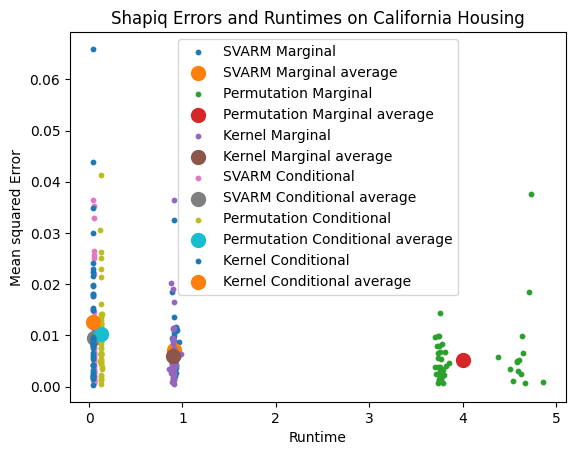

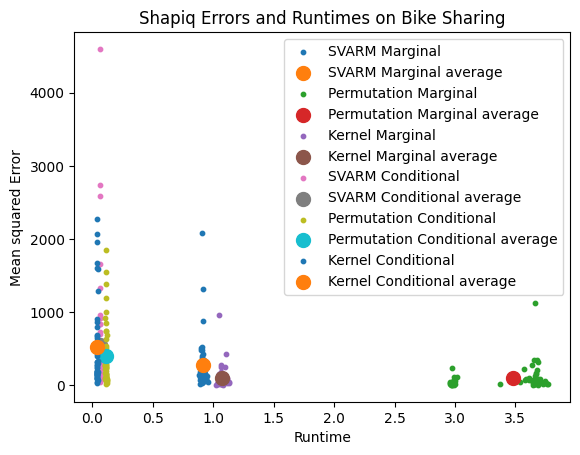

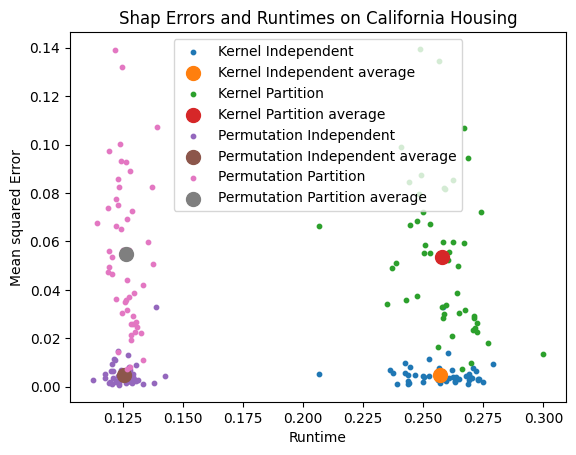

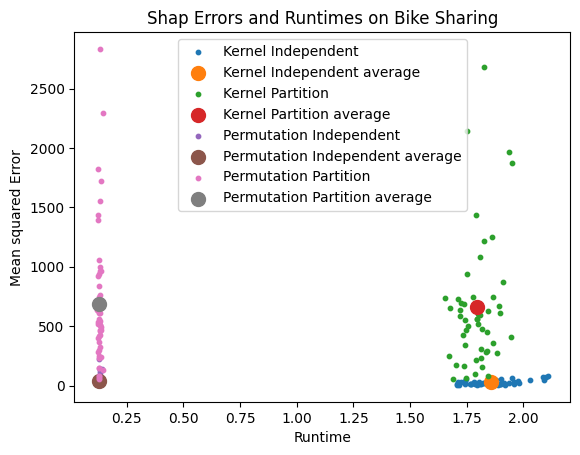

In [62]:
import matplotlib.pyplot as plt

labels_shapiq = [
    "SVARM Marginal",
    "Permutation Marginal",
    "Kernel Marginal",
    "SVARM Conditional",
    "Permutation Conditional",
    "Kernel Conditional",
]
labels_shap = [
    "Kernel Independent",
    "Kernel Partition",
    "Permutation Independent",
    "Permutation Partition",
]

for runtime_list, error_list in zip(runtimes_california_housing, errors_california_housing):
    plt.scatter(
        runtime_list,
        error_list,
        label=labels_shapiq[runtimes_california_housing.index(runtime_list)],
        s=10,
    )
    plt.scatter(
        sum(runtime_list) / len(runtime_list),
        sum(error_list) / len(error_list),
        label=f"{labels_shapiq[runtimes_california_housing.index(runtime_list)]} average",
        s=100,
    )
plt.legend()
plt.xlabel("Runtime")
plt.ylabel("Mean squared Error")
plt.title("Shapiq Errors and Runtimes on California Housing")
plt.show()

for runtime_list, error_list in zip(runtimes_bike_sharing, errors_bike_sharing):
    plt.scatter(
        runtime_list,
        error_list,
        label=labels_shapiq[runtimes_bike_sharing.index(runtime_list)],
        s=10,
    )
    plt.scatter(
        sum(runtime_list) / len(runtime_list),
        sum(error_list) / len(error_list),
        label=f"{labels_shapiq[runtimes_bike_sharing.index(runtime_list)]} average",
        s=100,
    )
plt.legend()
plt.xlabel("Runtime")
plt.ylabel("Mean squared Error")
plt.title("Shapiq Errors and Runtimes on Bike Sharing")
plt.show()

for runtime_list, error_list in zip(
    runtimes_california_housing_shap, errors_california_housing_shap
):
    plt.scatter(
        runtime_list,
        error_list,
        label=labels_shap[runtimes_california_housing_shap.index(runtime_list)],
        s=10,
    )
    plt.scatter(
        sum(runtime_list) / len(runtime_list),
        sum(error_list) / len(error_list),
        label=f"{labels_shap[runtimes_california_housing_shap.index(runtime_list)]} average",
        s=100,
    )
plt.legend()
plt.xlabel("Runtime")
plt.ylabel("Mean squared Error")
plt.title("Shap Errors and Runtimes on California Housing")
plt.show()

for runtime_list, error_list in zip(runtimes_bike_sharing_shap, errors_bike_sharing_shap):
    plt.scatter(
        runtime_list,
        error_list,
        label=labels_shap[runtimes_bike_sharing_shap.index(runtime_list)],
        s=10,
    )
    plt.scatter(
        sum(runtime_list) / len(runtime_list),
        sum(error_list) / len(error_list),
        label=f"{labels_shap[runtimes_bike_sharing_shap.index(runtime_list)]} average",
        s=100,
    )
plt.legend()
plt.xlabel("Runtime")
plt.ylabel("Mean squared Error")
plt.title("Shap Errors and Runtimes on Bike Sharing")
plt.show()

Visualizing Runtimes and Error for every combination of Approximator and Imputer for both shapiq and shap on each dataset.

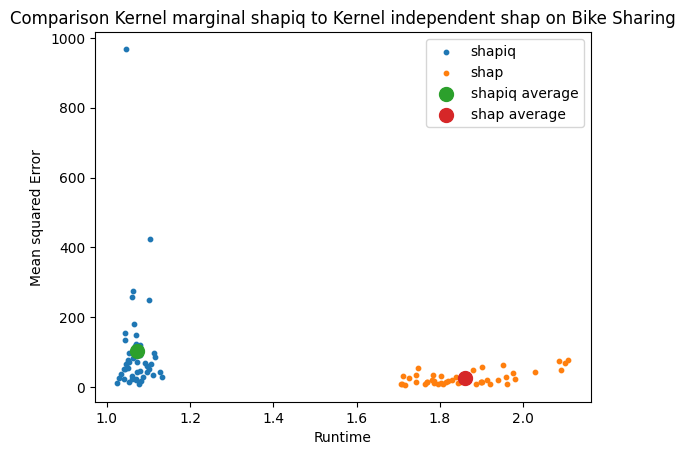

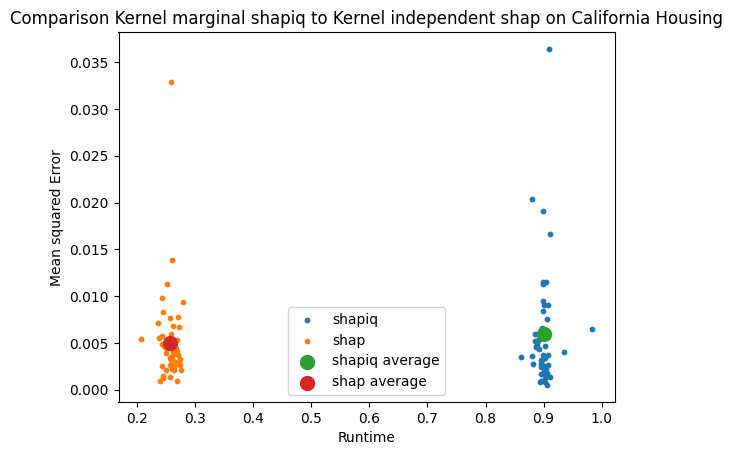

In [58]:
plt.scatter(runtimes_bike_sharing[2], errors_bike_sharing[2], label="shapiq", s=10)
plt.scatter(runtimes_bike_sharing_shap[0], errors_bike_sharing_shap[0], label="shap", s=10)
plt.scatter(
    sum(runtimes_bike_sharing[2]) / len(runtimes_bike_sharing[2]),
    sum(errors_bike_sharing[2]) / len(errors_bike_sharing[2]),
    label="shapiq average",
    s=100,
)
plt.scatter(
    sum(runtimes_bike_sharing_shap[0]) / len(runtimes_bike_sharing_shap[0]),
    sum(errors_bike_sharing_shap[0]) / len(errors_bike_sharing_shap[0]),
    label="shap average",
    s=100,
)
plt.xlabel("Runtime")
plt.ylabel("Mean squared Error")
plt.title("Comparison Kernel marginal shapiq to Kernel independent shap on Bike Sharing")
plt.legend()
plt.show()
plt.scatter(runtimes_california_housing[2], errors_california_housing[2], label="shapiq", s=10)
plt.scatter(
    runtimes_california_housing_shap[0], errors_california_housing_shap[0], label="shap", s=10
)
plt.scatter(
    sum(runtimes_california_housing[2]) / len(runtimes_california_housing[2]),
    sum(errors_california_housing[2]) / len(errors_california_housing[2]),
    label="shapiq average",
    s=100,
)
plt.scatter(
    sum(runtimes_california_housing_shap[0]) / len(runtimes_california_housing_shap[0]),
    sum(errors_california_housing_shap[0]) / len(errors_california_housing_shap[0]),
    label="shap average",
    s=100,
)
plt.xlabel("Runtime")
plt.ylabel("Mean squared Error")
plt.title("Comparison Kernel marginal shapiq to Kernel independent shap on California Housing")
plt.legend()
plt.show()

Comparing the shapiq Kernel Explainer with the marginal Imputer to shaps Kernel explainer with the independent masker on both datasets.

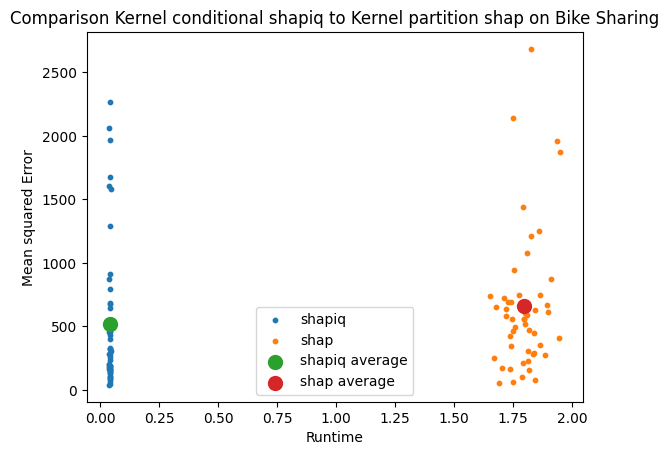

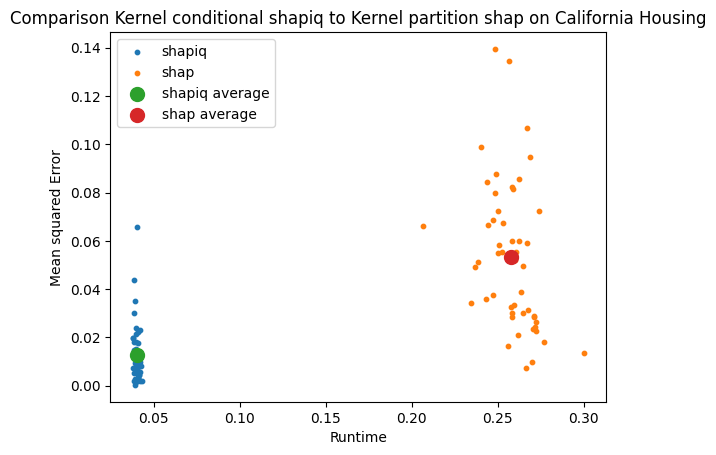

In [57]:
plt.scatter(runtimes_bike_sharing[5], errors_bike_sharing[5], label="shapiq", s=10)
plt.scatter(runtimes_bike_sharing_shap[1], errors_bike_sharing_shap[1], label="shap", s=10)
plt.scatter(
    sum(runtimes_bike_sharing[5]) / len(runtimes_bike_sharing[5]),
    sum(errors_bike_sharing[5]) / len(errors_bike_sharing[5]),
    label="shapiq average",
    s=100,
)
plt.scatter(
    sum(runtimes_bike_sharing_shap[1]) / len(runtimes_bike_sharing_shap[1]),
    sum(errors_bike_sharing_shap[1]) / len(errors_bike_sharing_shap[1]),
    label="shap average",
    s=100,
)
plt.xlabel("Runtime")
plt.ylabel("Mean squared Error")
plt.title("Comparison Kernel conditional shapiq to Kernel partition shap on Bike Sharing")
plt.legend()
plt.show()
plt.scatter(runtimes_california_housing[5], errors_california_housing[5], label="shapiq", s=10)
plt.scatter(
    runtimes_california_housing_shap[1], errors_california_housing_shap[1], label="shap", s=10
)
plt.scatter(
    sum(runtimes_california_housing[5]) / len(runtimes_california_housing[5]),
    sum(errors_california_housing[5]) / len(errors_california_housing[5]),
    label="shapiq average",
    s=100,
)
plt.scatter(
    sum(runtimes_california_housing_shap[1]) / len(runtimes_california_housing_shap[1]),
    sum(errors_california_housing_shap[1]) / len(errors_california_housing_shap[1]),
    label="shap average",
    s=100,
)
plt.xlabel("Runtime")
plt.ylabel("Mean squared Error")
plt.title("Comparison Kernel conditional shapiq to Kernel partition shap on California Housing")
plt.legend()
plt.show()

Comparing the shapiq Kernel Explainer with the conditional Imputer to shaps Kernel explainer with the partition masker on both datasets.

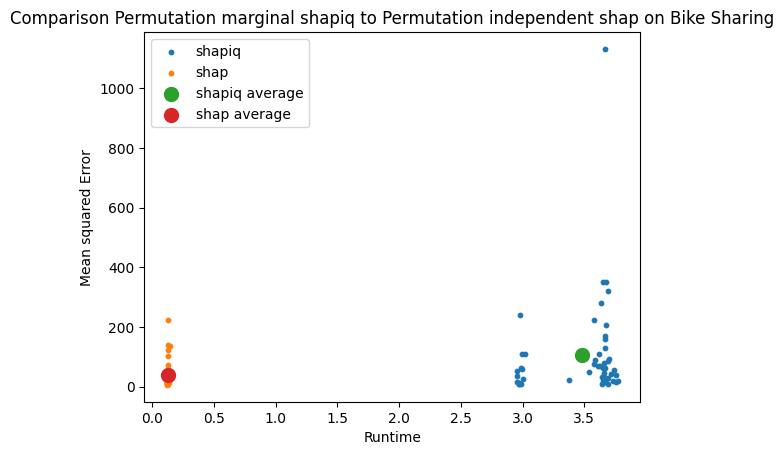

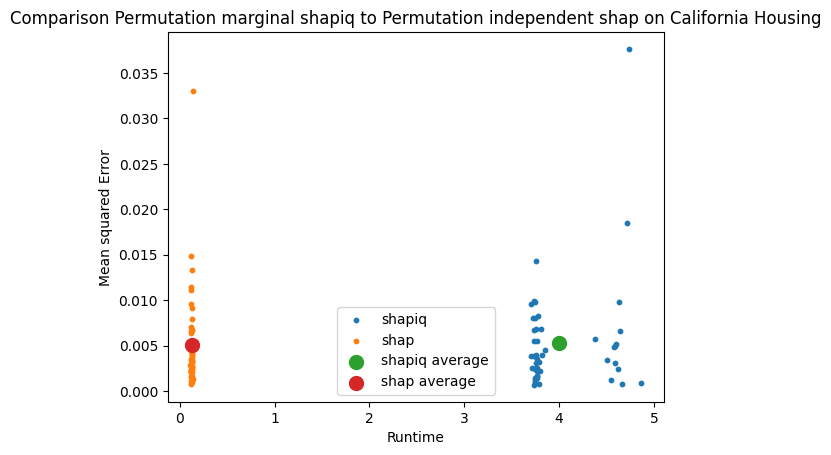

In [53]:
plt.scatter(runtimes_bike_sharing[1], errors_bike_sharing[1], label="shapiq", s=10)
plt.scatter(runtimes_bike_sharing_shap[2], errors_bike_sharing_shap[2], label="shap", s=10)
plt.scatter(
    sum(runtimes_bike_sharing[1]) / len(runtimes_bike_sharing[1]),
    sum(errors_bike_sharing[1]) / len(errors_bike_sharing[1]),
    label="shapiq average",
    s=100,
)
plt.scatter(
    sum(runtimes_bike_sharing_shap[2]) / len(runtimes_bike_sharing_shap[2]),
    sum(errors_bike_sharing_shap[2]) / len(errors_bike_sharing_shap[2]),
    label="shap average",
    s=100,
)
plt.xlabel("Runtime")
plt.ylabel("Mean squared Error")
plt.title("Comparison Permutation marginal shapiq to Permutation independent shap on Bike Sharing")
plt.legend()
plt.show()
plt.scatter(runtimes_california_housing[1], errors_california_housing[1], label="shapiq", s=10)
plt.scatter(
    runtimes_california_housing_shap[2], errors_california_housing_shap[2], label="shap", s=10
)
plt.scatter(
    sum(runtimes_california_housing[1]) / len(runtimes_california_housing[1]),
    sum(errors_california_housing[1]) / len(errors_california_housing[1]),
    label="shapiq average",
    s=100,
)
plt.scatter(
    sum(runtimes_california_housing_shap[2]) / len(runtimes_california_housing_shap[2]),
    sum(errors_california_housing_shap[2]) / len(errors_california_housing_shap[2]),
    label="shap average",
    s=100,
)
plt.xlabel("Runtime")
plt.ylabel("Mean squared Error")
plt.title(
    "Comparison Permutation marginal shapiq to Permutation independent shap on California Housing"
)
plt.legend()
plt.show()

Comparing the shapiq Permutation Explainer with the marginal Imputer to shaps Permutation explainer with the independent masker on both datasets.

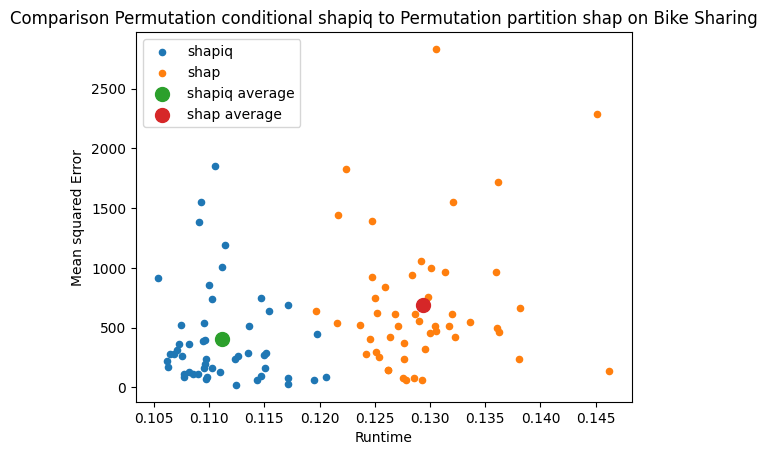

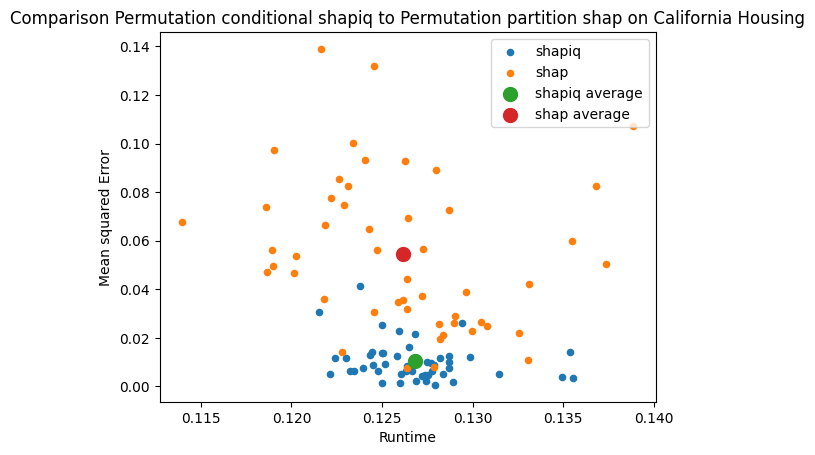

In [52]:
plt.scatter(runtimes_bike_sharing[4], errors_bike_sharing[4], label="shapiq", s=20)
plt.scatter(runtimes_bike_sharing_shap[3], errors_bike_sharing_shap[3], label="shap", s=20)
plt.scatter(
    sum(runtimes_bike_sharing[4]) / len(runtimes_bike_sharing[4]),
    sum(errors_bike_sharing[4]) / len(errors_bike_sharing[4]),
    label="shapiq average",
    s=100,
)
plt.scatter(
    sum(runtimes_bike_sharing_shap[3]) / len(runtimes_bike_sharing_shap[3]),
    sum(errors_bike_sharing_shap[3]) / len(errors_bike_sharing_shap[3]),
    label="shap average",
    s=100,
)
plt.xlabel("Runtime")
plt.ylabel("Mean squared Error")
plt.title("Comparison Permutation conditional shapiq to Permutation partition shap on Bike Sharing")
plt.legend()
plt.show()
plt.scatter(runtimes_california_housing[4], errors_california_housing[4], label="shapiq", s=20)
plt.scatter(
    runtimes_california_housing_shap[3], errors_california_housing_shap[3], label="shap", s=20
)
plt.scatter(
    sum(runtimes_california_housing[4]) / len(runtimes_california_housing[4]),
    sum(errors_california_housing[4]) / len(errors_california_housing[4]),
    label="shapiq average",
    s=100,
)
plt.scatter(
    sum(runtimes_california_housing_shap[3]) / len(runtimes_california_housing_shap[3]),
    sum(errors_california_housing_shap[3]) / len(errors_california_housing_shap[3]),
    label="shap average",
    s=100,
)
plt.xlabel("Runtime")
plt.ylabel("Mean squared Error")
plt.title(
    "Comparison Permutation conditional shapiq to Permutation partition shap on California Housing"
)
plt.legend()
plt.show()

Comparing the shapiq Permutation Explainer with the conditional Imputer to shaps Permutation explainer with the partition masker on both datasets.